In [0]:
"""Importing all the relevant libraries we need."""

import pandas as pd # For data frames
import numpy as np # For math and efficient arrays
import matplotlib.pyplot as plt # For plotting and visualizing data

# So plots appear in this notebook
%matplotlib inline

In [0]:
""" Grab all the data from github, and read it into dataframes"""

# Get the housing price data
housing_data = pd.read_csv('https://raw.githubusercontent.com/Mvalentino92/JAVA/master/train.csv')

# Print the shape of the data, to see how many instances and features there are
print('There are',housing_data.shape[0],'instances,',housing_data.shape[1]-1,
      'features and of course 1 label.')

There are 1460 instances, 80 features and of course 1 label.


In [0]:
# EXERCISE: Is there any feature that should be immediately taken out?
# Maybe there's one thats there, but it really doesn't supply any reasonably correlated info to salesprice.
# Don't think too hard or far when looking! Just take this out right away!

# its the first one! Id
housing_data = housing_data.drop('Id',axis=1)

In [0]:
# Lets seperate the features from the labels
features = housing_data.drop('SalePrice',axis=1)
labels = housing_data['SalePrice']

In [0]:
# Lets split the data between categorical and numerical features so we can operate on each easier, and then recombine
features_cat = pd.DataFrame()
features_num = pd.DataFrame()
for ft in features.columns:
    if np.dtype(features[ft]) is np.dtype('O'):
        features_cat[ft] = features[ft]
    else:
        features_num[ft] = features[ft]

In [0]:
# Lets replace all the NaNs in the categorical dataframe with Missing
for ft in features_cat.columns:
        features_cat[ft].fillna('Missing',inplace=True)

In [0]:
# Now lets onehot encode this, it will return a matrix, so lets call it X_cat to distinguish from dataframes
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse=False)
X_cat = onehot.fit_transform(features_cat)

In [0]:
# Alright, now let's split the numerical features
# Since we need to combine the numerical and previously-categorical features back,
# We need to use a specific seed and test_size
test_size = 0.20
random_state=23

from sklearn.model_selection import train_test_split
train_features_num, test_features_num = train_test_split(features_num,test_size=test_size,random_state=random_state)

In [0]:
# Okay, now lets use an imputer to replace the NaNs for the numerical features
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputer.fit(train_features_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [0]:
# The imputer will return a matrix, so we'll call is X_num
# Let's fit it to both train and test data
X_train_num = imputer.transform(train_features_num)
X_test_num = imputer.transform(test_features_num)

In [0]:
# Now let's split the previously-categorical feature matrix
X_train_cat, X_test_cat = train_test_split(X_cat,test_size=test_size,random_state=random_state)

In [0]:
# And let's combine all the training and test data now
X_train = np.hstack((X_train_num,X_train_cat))
X_test = np.hstack((X_test_num,X_test_cat))

In [0]:
# Finally, let's actually split the labels! 
y_train,y_test = train_test_split(np.array(labels),test_size=test_size,random_state=random_state)

In [0]:
# Now since the values are all over the place, let's use a scaler on the data
# Once again, you fit with training data, and transform on training and test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# EXERCISEEEE:  Maybe try a different Scaler, or change the parameters for Minmax?

In [0]:
# Time to build a simple linear regression and see how it works!
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# lets use it predict values
y_predict = reg.predict(X_test)

In [0]:
# And compare to the actual values using some accuracy metric
# Im going to wrap this in a function
import sklearn.metrics as mt

def print_accuracies(y_test,y_predict):
    # Mean squared error
    print('The MSE is: ',mt.mean_squared_error(y_test,y_predict))

    # Mean log squared error, but lets check for negatives first!
    hasneg = any([ele < 0 for ele in y_predict])
    if not(hasneg):
        print('The MSLE is: ',mt.mean_squared_log_error(y_test,y_predict))

    # Mean absolute error 
    print('The MAE is: ',mt.mean_absolute_error(y_test,y_predict))

    # mean absolute percfent error
    MAPE = np.sum(np.abs((y_test - y_predict)/y_test))*100/len(y_test)
    print('The MAPE is: ',MAPE)

    # Plot it
    plt.scatter(y_test,y_predict)
    plt.scatter(y_test,y_test)

The MSE is:  1.117341477391939e+26
The MAE is:  933003099755.9812
The MAPE is:  1269793428.6079714


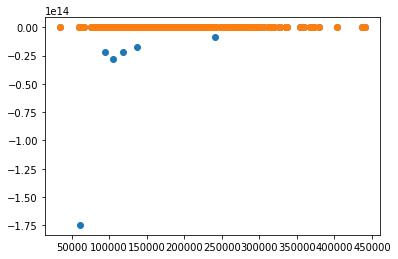

In [0]:
print_accuracies(y_test,y_predict)

814879785631267.4
The MSE is:  542747320.4197364
The MSLE is:  0.020901397100307865
The MAE is:  17254.876004055855
The MAPE is:  10.916812681613132


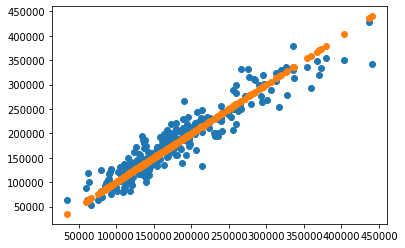

In [0]:
# Lets see what these coefficient are. I'm curious how with linear regression, a value can get to the magnitue of e14
print(np.max(reg.coef_))

# Hmm, lets drop a regularized model.
from sklearn.linear_model import Ridge

# Lets just set Alpha to 1, which is the default anyway
ridge = Ridge(alpha=8)

# Fit it
ridge.fit(X_train,y_train)

# And predict
y_predict = ridge.predict(X_test)

print_accuracies(y_test,y_predict)

The MSE is:  542747320.4197364
The MSLE is:  0.020901397100307865
The MAE is:  17254.876004055855
The MAPE is:  10.916812681613132


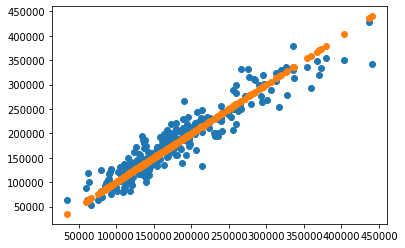

In [0]:
# EXERCISE TIME. So the original linear regression is pretty awful right? There's only 6 values that are INSANELY off.
# Could you change the limits of the plot so we can check out if all the other predictions were good?
# Despite the coefficients being too large and needing to be regularized.
# Or filter out these outlier predictions from the predictions (and corresponding label) to see what the accuracies are 
# without them? Try below!!

# Lets check it out, by just pulling out values that greater than say double the most expensive house.
most_expensive = np.max(y_test)
indices_to_keep = np.array([],dtype=int)

for i in range(0,len(y_test)):
    if np.abs(y_predict[i]) < most_expensive*2:
        indices_to_keep = np.append(indices_to_keep,i) 

print_accuracies(y_test[indices_to_keep],y_predict[indices_to_keep])

In [0]:
# Okay, let's try some polynomial features. Although, I don't want to use the onehot encoded features
# When I generate this. It's just going to multiply a lot of things by 0 and 1, and not really introduce 
# new information. Plus it saves us on A LOT of features!
# Let's only use the numerical features, luckily we have all that saved
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2) # Do quadratic only
poly.fit(X_train_num) # We can just fit it with the train data, and transform both
X_train_num_poly = poly.transform(X_train_num)
X_test_num_poly = poly.transform(X_test_num)

(292, 703)

In [0]:
# Now we're just going redo the last couple cells again below, they should look familiar!

In [0]:
# And let's combine all the training and test data now
X_train_poly = np.hstack((X_train_num_poly,X_train_cat))
X_test_poly = np.hstack((X_test_num_poly,X_test_cat))

(1168, 971)

In [0]:
# Now since the values are all over the place, let's use a scaler on the data
# Once again, you fit with training data, and transform on training and test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_poly)
X_train_poly = scaler.transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

In [0]:
# Time to build a polynomial regression and see how it works!
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train_poly,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Lets use it predict values
y_predict = reg.predict(X_test_poly)

The MSE is:  5.372108840385226e+25
The MAE is:  1221018299660.749
The MAPE is:  1044327294.6228932


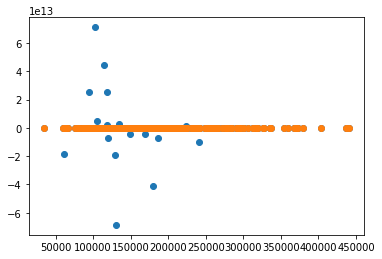

In [0]:
print_accuracies(y_test,y_predict)

In [0]:
# Alright, let's use regularization on this polynomial too, to prevent overfitting.
# We'll use ridge regression for this!
# Basically it's going to be the same stuff, but instead of LinearRegression model, we use Ridge!

# Dont need to redo any variables, they are all good where we left off.

# Lets just set Alpha to 1, which is the default anyway
ridge = Ridge(alpha=35)

# Fit it
ridge.fit(X_train_poly,y_train)

# And predict
y_predict = ridge.predict(X_test_poly)

The MSE is:  445776949.09805256
The MSLE is:  0.016763316477890516
The MAE is:  15080.577358702389
The MAPE is:  9.467714393509702


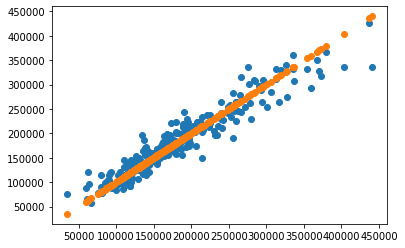

In [0]:
# And measure accuracy again
print_accuracies(y_test,y_predict)

The MSE is:  452934342.1431993
The MSLE is:  0.016640081452700486
The MAE is:  15092.372095816814
The MAPE is:  9.435879158068383


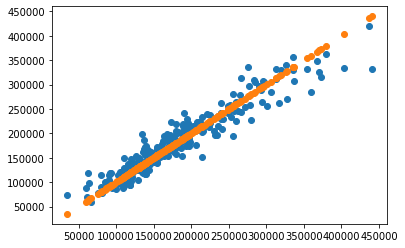

In [0]:
# THERE WE, THATS WHAT IM TALKING ABOUT.
# Not bad I guess 10 percent error. 


# EXERCIIIIISEEEE: Experiment with Alpha, try changing it to see what happens

# Lets impose a greater alpha
# Dont need to redo any variables, they are all good where we left off.
from sklearn.linear_model import Ridge

# Lets try alpha 50
ridge = Ridge(alpha=50)

# Fit it
ridge.fit(X_train_poly,y_train)

# And predict
y_predict = ridge.predict(X_test_poly)

# And measure accuracy again
print_accuracies(y_test,y_predict)

In [0]:
# Alright, let's use a random forest now.
# But first let's redo our training and test data, because I want to use the original
# and not the result of polynomial features. Also, we don't need scaling for decision trees.

# Actually, using Poly features for this works better and just keep scaling, makes no difference
from sklearn.ensemble import RandomForestRegressor

# Regularization of a decision tree is achieved by reducing the max depth. The default is None,
# We have 80 features, so let's try a depht of 10, with 256 trees.
rf = RandomForestRegressor(n_estimators=256,max_depth=15,min_samples_leaf=5,random_state=23)

# Fit the random forest
rf.fit(X_train_poly,y_train)

# And predict
y_predict = rf.predict(X_test_poly)

The MSE is:  481296447.2610429
The MSLE is:  0.020023333069183212
The MAE is:  15227.992612580258
The MAPE is:  9.860175727837687


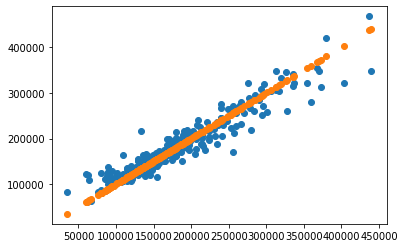

In [0]:
# And measure accuracy again
print_accuracies(y_test,y_predict)

In [0]:
# Hey pretty good!
# Alright lets try pythons gradient boosting, again we don't need scaling because it uses trees
from sklearn.ensemble import GradientBoostingRegressor

# Try with some default parameters
bst = GradientBoostingRegressor(subsample=0.65,learning_rate=0.025,n_estimators=512)

# Train it
bst.fit(X_train_poly,y_train)

# Get predictions
y_predict = bst.predict(X_test_poly)

The MSE is:  381098721.7751767
The MSLE is:  0.015421152859103495
The MAE is:  13339.264436234787
The MAPE is:  8.492316173423573


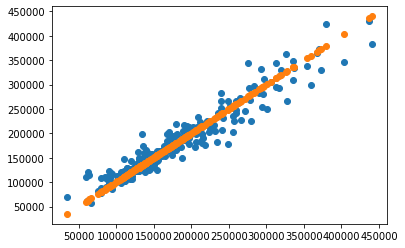

In [0]:
# And measure accuracy again
print_accuracies(y_test,y_predict)

Agree!

OverallQual :  0.6281180342132159
GrLivArea :  0.11709943048024106
TotalBsmtSF :  0.03502756052917746
BsmtFinSF1 :  0.028698081348085446
1stFlrSF :  0.02192043065330044
GarageCars :  0.015623212819577745
GarageArea :  0.01476457824178977
2ndFlrSF :  0.013526275918403025
FullBath :  0.01037248122998587
YearBuilt :  0.010368725361987036
Index is:  3


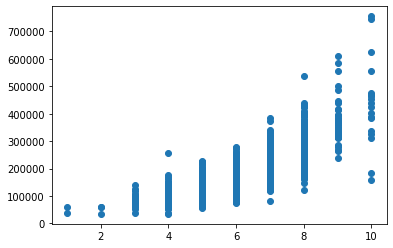

In [0]:
# Alright similar performance, would we get more of a return for changing the number of estimators?
# We do! (I changed it from 64 to 256 and the MSLE went from 0.022 to 0.015!!!) A new record!
# Will change if you run this, not setting seed.

# Now, let's try neural networks, but first lets check something from the random forest regressor.
# Theres a variable bound to the predictor called feature_importances_ which breaks down the importance
# Of each feature percent wise (all add up to 1).
# We first need to create an array of all the feature lables.
# Luckily we can do this easily by grabbing the column names from features_num,
# And from building the feature names from the onehot encoder.
rf = RandomForestRegressor(n_estimators=256,max_depth=15,min_samples_leaf=5,random_state=23)
rf.fit(X_train,y_train)
y_predict = rf.predict(X_test)

category_names = features_num.columns.copy()
for cat in onehot.categories_:
    category_names = np.append(category_names,cat)

# Lets confirm the dimensions agree
if len(category_names == X_train.shape[1]):
    print("Agree!\n")

# Now lets argsort and list the top 10 features and their contribution
index_sort =  np.argsort(rf.feature_importances_)
index_sort = index_sort[::-1]
category_names = category_names[index_sort]
feat_imp = rf.feature_importances_[index_sort]

for i in range(0,10):
    print(category_names[i],": ",feat_imp[i])

# WOW, overall quality has the most impact on the data BY FAR. According to random forest.
# Lets plot the correlation with that real quick
plt.scatter(housing_data['OverallQual'],housing_data['SalePrice'])

# Its hard to tell the relationship since it has ordinal values.
# It looks like it might a higher order than linear.
# Regardless, lets make a custom polynomial fitter to add a few extra features
# using OverallQual. Lets add extra columns, this feature multiplied by every other feature

# Lets print the index of this X_train and X_test
print("Index is: ",index_sort[0])

In [0]:
# Custom base to achieve the above
from sklearn.base import BaseEstimator,TransformerMixin
class CustomPolyFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,index):
        self.index = index
    def fit(self, X, y = None):
        return self
    def transform(self,X, y = None):
        target = X[:,self.index].reshape(-1,1)
        for coldex in range(0,X.shape[1]):
            X = np.hstack((X,X[:,coldex].reshape(-1,1)*target))
        return X

In [0]:
# Apply it. 
custom_poly = CustomPolyFeatures(index_sort[0])
X_train_cp = custom_poly.fit_transform(X_train)
X_test_cp = custom_poly.fit_transform(X_test)

The MSE is:  521362408.545238
The MSLE is:  0.019553673599262168
The MAE is:  16625.035674073988
The MAPE is:  10.418409699880648


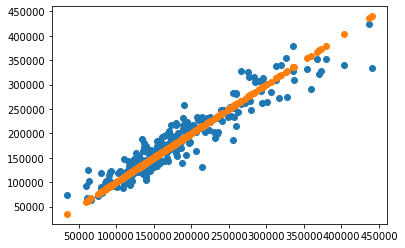

In [0]:
# Lets try ridge regression again
scaler = MinMaxScaler()
scaler.fit(X_train_cp)
X_train_cp = scaler.transform(X_train_cp)
X_test_cp = scaler.transform(X_test_cp)

ridge = Ridge(alpha=32)
ridge.fit(X_train_cp,y_train)

y_predict = ridge.predict(X_test_cp)

print_accuracies(y_test,y_predict)

The MSE is:  628162006.2777566
The MSLE is:  0.02161877566000603
The MAE is:  17563.314025042808
The MAPE is:  10.731750621276376


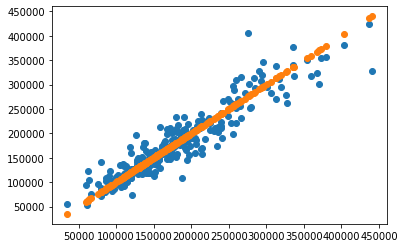

In [0]:
# Across all the accuracy tests, more or less the same results as the original
# Okay, lets do neural networks, so far our winner is gradient boosting

# lets quickly get and scale fresh values again
X_train = np.hstack((X_train_num,X_train_cat))
X_test = np.hstack((X_test_num,X_test_cat))
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

import tensorflow as tf
from tensorflow import keras

# Change these like how I have them.
# You can use any of the activation functions found here
# https://keras.io/activations
# Change the activation, or change the number in the layers. Or add a new layer 
# Just make sure it still matches.
input_ = keras.layers.Input(shape=X_train.shape[1:])
layer1 = keras.layers.Dense(128,activation='relu')(input_)
layer2 = keras.layers.Dense(256,activation='exponential')(layer1)
layer3 = keras.layers.Dense(100,activation='elu')(layer2)
layer4 = keras.layers.Dense(256,activation='exponential')(layer3)
layer5 = keras.layers.Dense(128,activation='relu')(layer4)
output_ = keras.layers.Dense(1)(layer5)

model = keras.Model(inputs=input_,outputs=output_)
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,epochs=256,verbose=0)

y_predict = model.predict(X_test).T[0]

print_accuracies(y_test,y_predict)

In [0]:
# Let's get python to optimize the parameters of a neural network for us. 
# Too much work to manually do. 
# Going to use the dual annealing optimizer (simulated annelaing), but i'm going to throw in some
# rounding to the objective function, since this sim anneal implementation is for real values
# It's not ideal at all, but it's a quick way to let me use the function even if paramters I have are 
# categorical (all the activation function)
# This in general will be essentially a random search. The amount of max function calls
# I will impose on this process, really won't allow the algorithms mechanisms to work.
# but hey, it's quicker than writing a random search myself! (maybe)

# First we need to define our objective function
count = 0
def obj(x, *args):

    # The elements of x, hold our values for the neural network
    # The first 3 represent the number of neurons for each layer (we're building 3 layers)
    # The next 3, are the integer encodings for what activation function to use (where args will handle)
    # And finally the number of epochs.
    # Also, args actually has all  the training and test data too.
    # Let's begin to build the neural network
    X_train,y_train,X_test,y_test = args[5:] # (0 through 4 are the encodings for activation layers)

    # Round everything
    x = list(map(lambda x: np.int(np.round(x)),x))

    # Get activation functions from args
    act1 = args[x[3]]
    act2 = args[x[4]]
    act3 = args[x[5]]

    # Build the layers
    input_ = keras.layers.Input(shape=X_train.shape[1:])
    layer1 = keras.layers.Dense(x[0],activation=act1)(input_)
    layer2 = keras.layers.Dense(x[1],activation=act2)(layer1)
    layer3 = keras.layers.Dense(x[2],activation=act3)(layer2)
    output_ = keras.layers.Dense(1)(layer3)

    # Build model
    model = keras.Model(inputs=input_,outputs=output_)
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.fit(X_train,y_train,epochs=x[6],verbose=0)

    # Get prediction
    y_predict = np.nan_to_num(model.predict(X_test).T[0])

    # Use mean absolute value
    val = mt.mean_absolute_error(y_test,y_predict)
    global count
    print('Finished function call: ',count)
    print('With parameters: ',x)
    print('And MAE: ',val,'\n')
    count = count + 1
    return val

In [0]:
# Lets import scipy and set it up
from scipy.optimize import dual_annealing
bounds = [(16,256),(16,256),(16,256),(0,4),(0,4),(0,4),(64,512)]
args = ('exponential','relu','sigmoid','elu','tanh',X_train,y_train,X_test,y_test)
retval = dual_annealing(obj,bounds=bounds,args=args,maxfun=250,no_local_search=True)

# Will print out parameter for neural net, and function call. (See how its moving through values)

Finished function call:  0
With parameters:  [97, 108, 185, 2, 1, 2, 135]
And MAE:  175522.83761972922 

Finished function call:  1
With parameters:  [82, 169, 169, 3, 2, 2, 327]
And MAE:  174655.64731211204 

Finished function call:  2
With parameters:  [207, 54, 55, 1, 3, 1, 325]
And MAE:  16809.671005458047 

Finished function call:  3
With parameters:  [35, 176, 123, 2, 3, 4, 360]
And MAE:  174410.1166724636 

Finished function call:  4
With parameters:  [111, 198, 199, 0, 3, 0, 420]
And MAE:  176072.48630136985 

Finished function call:  5
With parameters:  [28, 77, 78, 2, 2, 3, 188]
And MAE:  53536.76038099315 

Finished function call:  6
With parameters:  [202, 108, 109, 3, 2, 3, 223]
And MAE:  18312.622859589042 

Finished function call:  7
With parameters:  [168, 211, 256, 2, 4, 1, 418]
And MAE:  17172.57736916738 

Finished function call:  8
With parameters:  [98, 54, 55, 1, 3, 1, 325]
And MAE:  17911.88032427226 

Finished function call:  9
With parameters:  [207, 54, 55, 1,

Layer1 has 240 neurons with activation sigmoid
Layer1 has 54 neurons with activation elu
Layer1 has 72 neurons with activation elu
And 245 epochs

The MSE is:  473730955.0598383
The MSLE is:  0.018044680369075496
The MAE is:  15500.460455907534
The MAPE is:  9.69925449230254


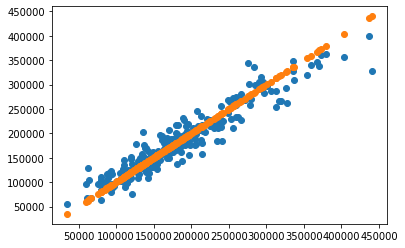

In [0]:
# Let's grab the parameters and construct the neural network with them
x = list(map(lambda x: np.int(np.round(x)),retval.x))

# Same code as before

act1 = args[x[3]]
act2 = args[x[4]]
act3 = args[x[5]]

# Build the layers
input_ = keras.layers.Input(shape=X_train.shape[1:])
layer1 = keras.layers.Dense(x[0],activation=act1)(input_)
layer2 = keras.layers.Dense(x[1],activation=act2)(layer1)
layer3 = keras.layers.Dense(x[2],activation=act3)(layer2)
output_ = keras.layers.Dense(1)(layer3)

# Build model
model = keras.Model(inputs=input_,outputs=output_)
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,epochs=x[6],verbose=0)
y_predict = model.predict(X_test).T[0]

print('Layer1 has',x[0],'neurons with activation',act1)
print('Layer1 has',x[1],'neurons with activation',act2)
print('Layer1 has',x[2],'neurons with activation',act3)
print('And',x[6],'epochs\n')
print_accuracies(y_test,y_predict)